# 1. Importieren der benötigten Bibliotheken

# 2. Testdataset erstellen

In [37]:
import pytorch_train as pt
import torch
import os
import torch
import pandas as pd
import matplotlib.pyplot as plt
from torch import nn, cuda
from torchvision import datasets, transforms, models
from torchvision.transforms import ToTensor
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from torch.optim import Adam
import torch.optim as optim
from tqdm import tqdm
from pytorch_train import SimpleCNN

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

model = SimpleCNN()  # Instantiate the model
def get_model_path(directory):
    for filename in os.listdir(directory):
        if filename.endswith(".pth"):
            return os.path.join(directory, filename)
    return None

model_path = get_model_path("test/trained_model_txt/")
print(model_path)

# model_path = f'model/PyTorch_Trained_Models/model64-91acc-100.pth'
model.load_state_dict(torch.load(model_path, map_location=device))  # Load the state_dict
test_dataset = datasets.ImageFolder("data/output/val", transform=transform)

test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=True)

for inputs, _ in test_dataloader:
    inputs = inputs.to(device) 
    output = model(inputs)
    probabilities = torch.nn.functional.softmax(output, dim=1)
    predictions = torch.argmax(probabilities, dim=1)
    predictions_list = predictions.cpu().numpy().tolist()
    print(predictions_list)

   

[1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1]
[1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]
[1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0]
[0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1]
[1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1

## 2.1 Robustheit des ML-Models Testen auf Testbilder

In [38]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def test_model_robustness(model, test_dataloader, device):
    model.eval()  # Set the model to evaluation mode
    true_labels = []
    predicted_labels = []

    with torch.no_grad():  # Do not calculate gradients to speed up computation
        for inputs, labels in test_dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            output = model(inputs)
            probabilities = torch.nn.functional.softmax(output, dim=1)
            predictions = torch.argmax(probabilities, dim=1)

            true_labels.extend(labels.cpu().numpy())
            predicted_labels.extend(predictions.cpu().numpy())

    # Calculate metrics
    accuracy = accuracy_score(true_labels, predicted_labels)
    precision = precision_score(true_labels, predicted_labels, average='weighted')
    recall = recall_score(true_labels, predicted_labels, average='weighted')
    f1 = f1_score(true_labels, predicted_labels, average='weighted')

    print(f'Accuracy: {accuracy}')
    print(f'Precision: {precision}')
    print(f'Recall: {recall}')
    print(f'F1 Score: {f1}')
    return accuracy, precision, recall, f1


test_model_robustness(model, test_dataloader, device)

Accuracy: 0.9125
Precision: 0.9126207309071122
Recall: 0.9125
F1 Score: 0.9124944215612129


(0.9125, 0.9126207309071122, 0.9125, 0.9124944215612129)

## 2.2 Testdaten verrauschen

### `add_noise` Funktion
Die Funktion `add_noise` fügt einem gegebenen Bild Rauschen hinzu.

#### Parameter

- `images`: Die Bilder, zu denen Rauschen hinzugefügt werden soll.
- `noise_factor`: Der Faktor, der bestimmt, wie viel Rauschen hinzugefügt wird. Standardmäßig ist dieser Wert 0.5.

#### Rückgabewert

Die Funktion gibt die verrauschten Bilder zurück.

### `add_noise_and_test` Funktion

Die Funktion `add_noise_and_test` fügt den Testbildern Rauschen hinzu und testet dann das Modell mit diesen verrauschten Bildern.

#### Parameter

- `model`: Das zu testende Modell.
- `test_dataloader`: Ein DataLoader, der die Testdaten bereitstellt.
- `device`: Das Gerät, auf dem das Modell ausgeführt wird (z.B. 'cpu' oder 'cuda').
- `noise_factor`: Der Faktor, der bestimmt, wie viel Rauschen hinzugefügt wird. Standardmäßig ist dieser Wert 0.5.

#### Funktionsweise

Die Funktion fügt den Testbildern Rauschen hinzu und erstellt dann einen neuen DataLoader mit den verrauschten Bildern. Anschließend wird das Modell mit diesen verrauschten Bildern getestet.

### Beispiel

```python
add_noise_and_test(model, test_dataloader, device)
```

In diesem Beispiel wird die Funktion `add_noise_and_test` aufgerufen, um Rauschen zu den Testbildern hinzuzufügen und dann das Modell `model` mit diesen verrauschten Bildern zu testen. Die Testdaten werden vom `test_dataloader` bereitgestellt und das Modell wird auf dem `device` ausgeführt. Der Rauschfaktor beträgt 0.5.

In [39]:
def add_noise(images, noise_factor=0.5):
    noise = torch.randn_like(images) * noise_factor
    noisy_images = images + noise
    noisy_images = torch.clamp(noisy_images, 0., 1.)
    return noisy_images

def add_noise_and_test(model, test_dataloader, device, noise_factor=0.5):
    noisy_images = []
    labels_list = []
    
    for inputs, labels in test_dataloader:
        inputs_noisy = add_noise(inputs, noise_factor)
        noisy_images.append(inputs_noisy)
        labels_list.append(labels)

    # Stack images and labels separately
    noisy_images = torch.cat(noisy_images)
    labels_list = torch.cat(labels_list)

    noisy_dataloader = torch.utils.data.DataLoader(list(zip(noisy_images, labels_list)), batch_size=test_dataloader.batch_size)

    test_model_robustness(model, noisy_dataloader, device)

# Verwendung der Funktion
add_noise_and_test(model, test_dataloader, device)



Accuracy: 0.7395
Precision: 0.7858584079045489
Recall: 0.7395
F1 Score: 0.728416114547149


## 2.3 Model auf verrauschte Bilder testen


### Dokumentation für `test_noise_robustness` Funktion

Die Funktion `test_noise_robustness` testet die Robustheit eines Modells gegenüber Bildrauschen. Sie nimmt ein Modell, einen DataLoader für Testdaten, ein Gerät und optionale Parameter für den Start-, End- und Schrittwert des Rauschfaktors an.

### Parameter

- `model`: Das zu testende Modell.
- `test_dataloader`: Ein DataLoader, der die Testdaten bereitstellt.
- `device`: Das Gerät, auf dem das Modell ausgeführt wird (z.B. 'cpu' oder 'cuda').
- `start_noise`: Der Startwert für den Rauschfaktor. Standardmäßig ist dieser Wert 0.0.
- `end_noise`: Der Endwert für den Rauschfaktor. Standardmäßig ist dieser Wert 1.0.
- `step`: Der Schrittwert, um den der Rauschfaktor bei jedem Durchlauf erhöht wird. Standardmäßig ist dieser Wert 0.1.

### Funktionsweise

Die Funktion fügt den Testbildern schrittweise Rauschen hinzu, beginnend mit dem `start_noise`-Wert und endend mit dem `end_noise`-Wert. Bei jedem Schritt wird das Modell mit den verrauschten Bildern getestet und die Genauigkeit, Precision, Recall und der F1-Score werden berechnet und neben einem Beispielbild angezeigt.

Wenn die Genauigkeit des Modells unter 70% fällt, wird der Test gestoppt.

### Beispiel

```python
test_noise_robustness(model, test_dataloader, device)
```

In diesem Beispiel wird die Funktion `test_noise_robustness` aufgerufen, um die Robustheit des Modells `model` gegenüber Bildrauschen zu testen. Die Testdaten werden vom `test_dataloader` bereitgestellt und das Modell wird auf dem `device` ausgeführt. Der Rauschfaktor startet bei 0.0 und endet bei 1.0, wobei er bei jedem Durchlauf um 0.1 erhöht wird.



Die Funktion `test_noise_robustness` testet die Robustheit eines Modells gegenüber Bildrauschen. Sie nimmt ein Modell, einen DataLoader für Testdaten, ein Gerät und optionale Parameter für den Start-, End- und Schrittwert des Rauschfaktors an.

### Parameter

- `model`: Das zu testende Modell.
- `test_dataloader`: Ein DataLoader, der die Testdaten bereitstellt.
- `device`: Das Gerät, auf dem das Modell ausgeführt wird (z.B. 'cpu' oder 'cuda').
- `start_noise`: Der Startwert für den Rauschfaktor. Standardmäßig ist dieser Wert 0.0.
- `end_noise`: Der Endwert für den Rauschfaktor. Standardmäßig ist dieser Wert 1.0.
- `step`: Der Schrittwert, um den der Rauschfaktor bei jedem Durchlauf erhöht wird. Standardmäßig ist dieser Wert 0.1.

### Funktionsweise

Die Funktion fügt den Testbildern schrittweise Rauschen hinzu, beginnend mit dem `start_noise`-Wert und endend mit dem `end_noise`-Wert. Bei jedem Schritt wird das Modell mit den verrauschten Bildern getestet und die Genauigkeit, Precision, Recall und der F1-Score werden berechnet und neben einem Beispielbild angezeigt.

Wenn die Genauigkeit des Modells unter 70% fällt, wird der Test gestoppt.

### Beispiel

```python
test_noise_robustness(model, test_dataloader, device)
```

In diesem Beispiel wird die Funktion `test_noise_robustness` aufgerufen, um die Robustheit des Modells `model` gegenüber Bildrauschen zu testen. Die Testdaten werden vom `test_dataloader` bereitgestellt und das Modell wird auf dem `device` ausgeführt. Der Rauschfaktor startet bei 0.0 und endet bei 1.0, wobei er bei jedem Durchlauf um 0.1 erhöht wird.

Test mit noise factor: 0.0
Accuracy: 0.781
Precision: 0.7905891159024575
Recall: 0.781
F1 Score: 0.7791508810572687


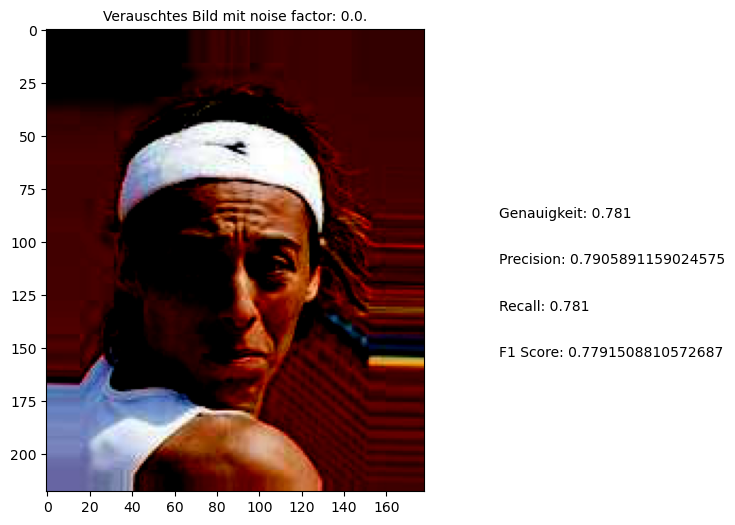

Test mit noise factor: 0.1
Accuracy: 0.783
Precision: 0.7931036194692191
Recall: 0.783
F1 Score: 0.7810860745547659


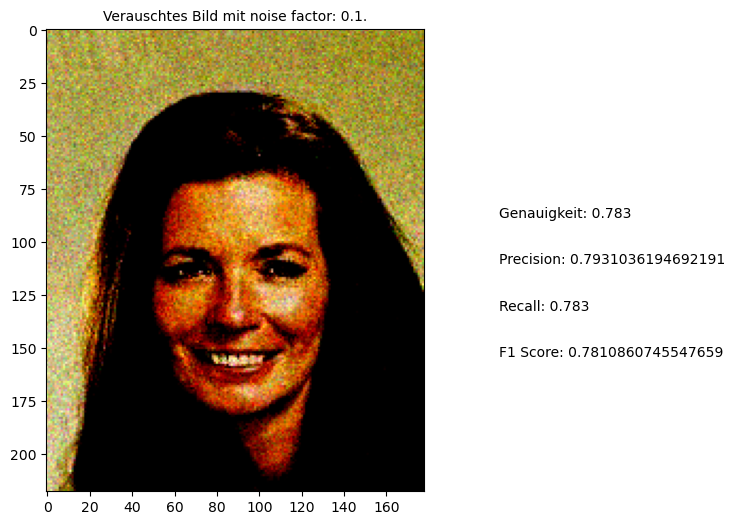

Test mit noise factor: 0.2
Accuracy: 0.7785
Precision: 0.7933054269888843
Recall: 0.7785
F1 Score: 0.7756348118043668


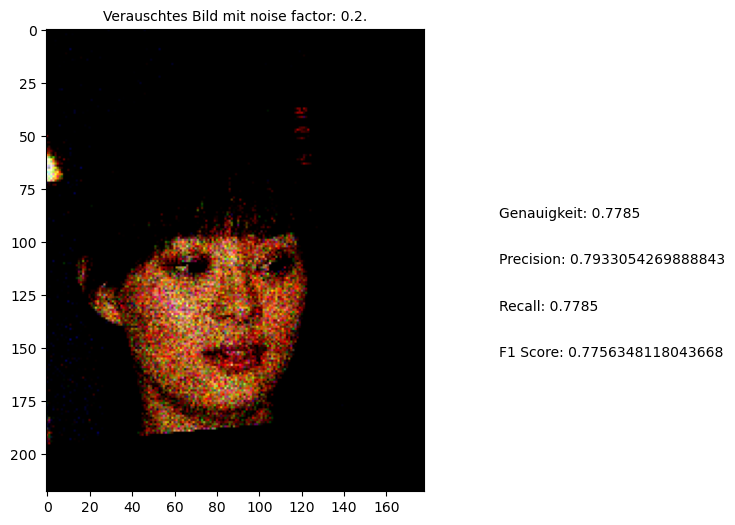

Test mit noise factor: 0.30000000000000004
Accuracy: 0.7685
Precision: 0.7918192167458535
Recall: 0.7685
F1 Score: 0.7637353394874674


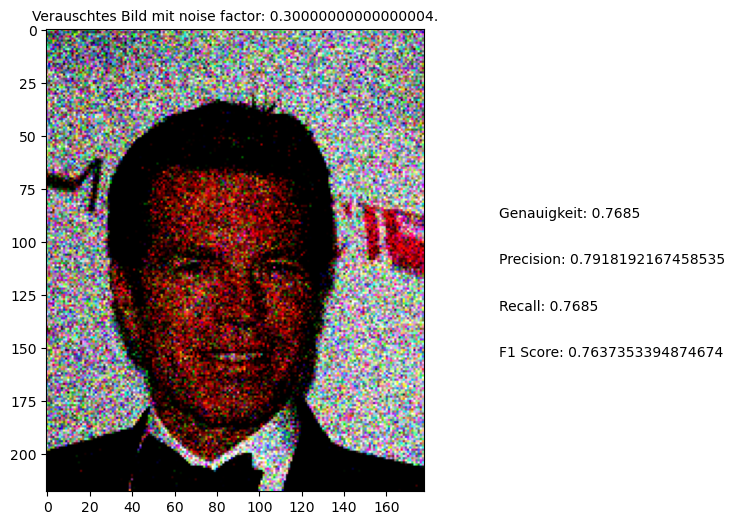

Test mit noise factor: 0.4
Accuracy: 0.756
Precision: 0.7876454705880368
Recall: 0.756
F1 Score: 0.7490417740360925


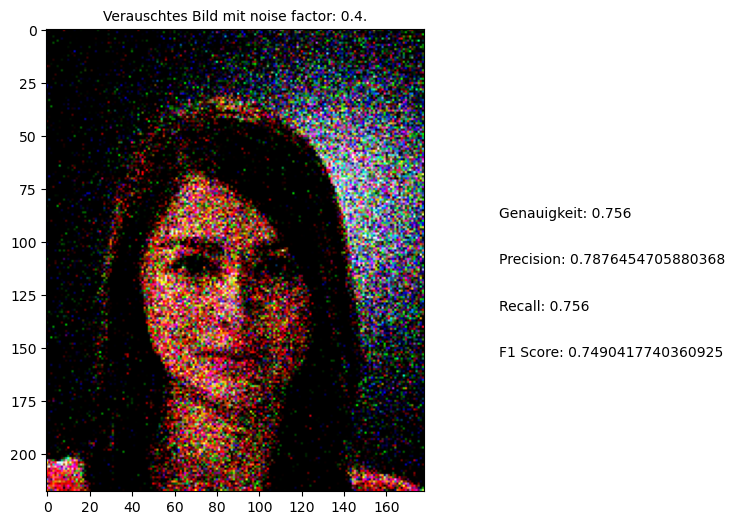

Test mit noise factor: 0.5
Accuracy: 0.7395
Precision: 0.7836956797092923
Recall: 0.7395
F1 Score: 0.7288685188467285


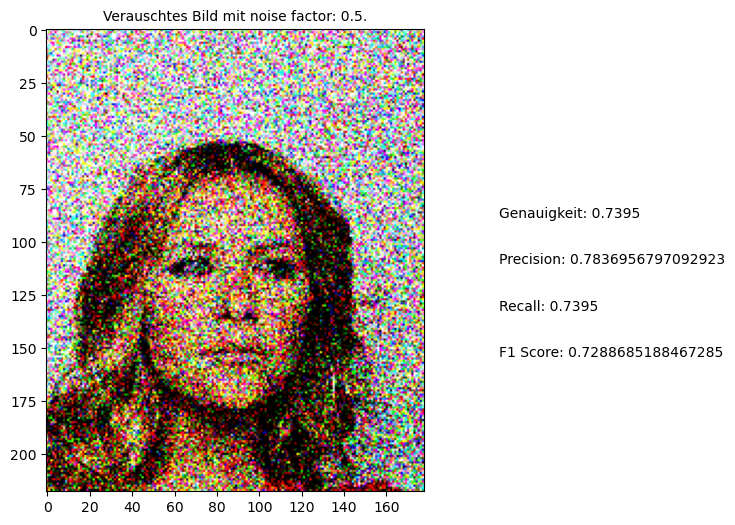

Test mit noise factor: 0.6
Accuracy: 0.7205
Precision: 0.7786136179571672
Recall: 0.7205
F1 Score: 0.7050278904995857


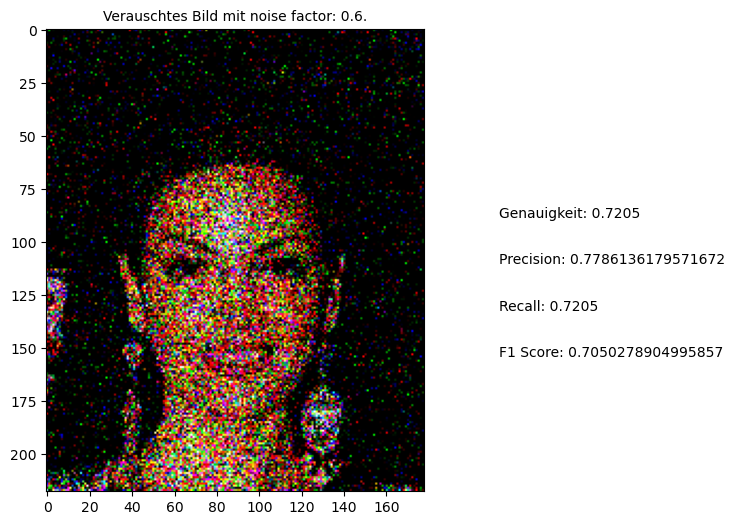

Test mit noise factor: 0.7
Accuracy: 0.6975
Precision: 0.7725384682382999
Recall: 0.6975
F1 Score: 0.6750152890533764


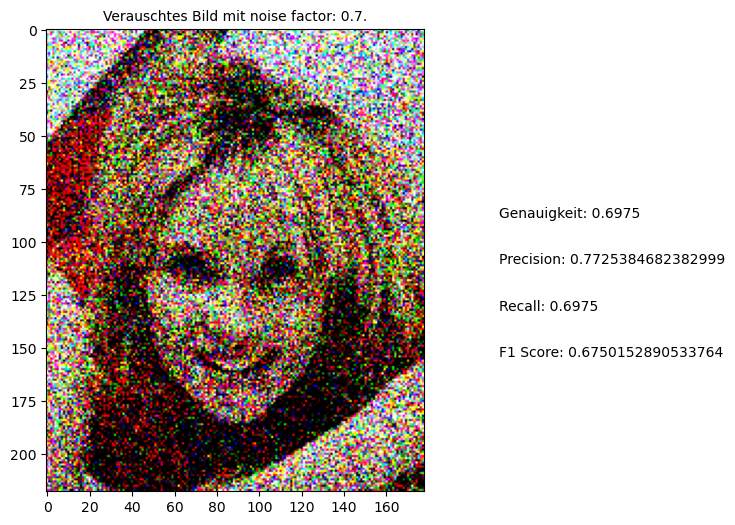

Genauigkeit unter 70% mit noise factor: 0.7. Test wird gestoppt.


In [54]:
def test_noise_robustness(model, test_dataloader, device, start_noise=0.0, end_noise=1.0, step=0.1):
    noise_factor = start_noise

    while noise_factor <= end_noise:
        noisy_images = []
        labels_list = []

        for inputs, labels in test_dataloader:
            inputs_noisy = add_noise(inputs, noise_factor)
            noisy_images.append(inputs_noisy)
            labels_list.append(labels)

        noisy_images = torch.cat(noisy_images)
        labels_list = torch.cat(labels_list)

        noisy_dataloader = torch.utils.data.DataLoader(list(zip(noisy_images, labels_list)), batch_size=test_dataloader.batch_size)

        print(f'Test mit noise factor: {noise_factor}')
        accuracy, precision,recall, f1 = test_model_robustness(model, noisy_dataloader, device)
        

        # Show a sample noisy image
        plt.figure(figsize=(12, 6))
        plt.title(f'Verauschtes Bild mit noise factor: {noise_factor}.', fontsize=10)
        plt.imshow(noisy_images[0].permute(1, 2, 0))
        plt.text(1.2, 0.6, f'Genauigkeit: {accuracy}', horizontalalignment='left', verticalalignment='center', transform=plt.gca().transAxes)
        plt.text(1.2, 0.5, f'Precision: {precision}', horizontalalignment='left', verticalalignment='center', transform=plt.gca().transAxes)
        plt.text(1.2, 0.4, f'Recall: {recall}', horizontalalignment='left', verticalalignment='center', transform=plt.gca().transAxes)
        plt.text(1.2, 0.3, f'F1 Score: {f1}', horizontalalignment='left', verticalalignment='center', transform=plt.gca().transAxes)
        plt.savefig(f"test/test-plots/plot{noise_factor}-img.png",)
        plt.show()

        if accuracy < 0.7:
            print(f'Genauigkeit unter 70% mit noise factor: {noise_factor}. Test wird gestoppt.')
            break

        noise_factor += step

# Verwendung der Funktion
test_noise_robustness(model, test_dataloader, device)

## 2.4 Testdaten mit Verzerrungen erstellen 


In [89]:
import torchvision.transforms.functional as TF


def add_distortion(image, distortion_factor=0.5):
    # Create the distortion matrix
    startpoints = torch.tensor([[0.0, 0.0], [1.0, 0.0], [0.0, 1.0], [1.0, 1.0]])
    endpoints = startpoints + torch.tensor([[0.0, distortion_factor], [0.0, -distortion_factor], [0.0, 0.0], [0.0, 0.0]])

    # Apply the distortion to the image
    distorted_image = TF.perspective(image, startpoints, endpoints)

    return distorted_image

# def add_distortion_and_test(model, test_dataloader, device, distortion_factor=0.0):
#     distorted_images = []
#     labels_list = []
#     while distortion_factor <= 1.0:
#         for inputs, labels in test_dataloader:
#             inputs_distorted = add_distortion(inputs, distortion_factor)
#             distorted_images.append(inputs_distorted)  # Append tensor directly
#             labels_list.append(labels)  # Append tensor directly

#         distorted_images = torch.stack(distorted_images)  # Convert list of tensors to tensor
#         labels_list = torch.cat(labels_list)

#         distorted_dataloader = torch.utils.data.DataLoader(list(zip(distorted_images, labels_list)), batch_size=test_dataloader.batch_size)

#         accuracy, recall, precision, f1 = test_model_robustness(model, distorted_dataloader, device)

#         # Show a sample distorted image
#         plt.figure(figsize=(2, 2))
#         plt.imshow(inputs_distorted[0].permute(1, 2, 0))
#         plt.title(f'Distorted Image with Distortion Factor: {distortion_factor}')
#         plt.text(1.2, 0.6, f'Genauigkeit: {accuracy}', horizontalalignment='left', verticalalignment='center', transform=plt.gca().transAxes)
#         plt.text(1.2, 0.5, f'Precision: {precision}', horizontalalignment='left', verticalalignment='center', transform=plt.gca().transAxes)
#         plt.text(1.2, 0.4, f'Recall: {recall}', horizontalalignment='left', verticalalignment='center', transform=plt.gca().transAxes)
#         plt.text(1.2, 0.3, f'F1 Score: {f1}', horizontalalignment='left', verticalalignment='center', transform=plt.gca().transAxes)
#         plt.savefig(f"test/test-plots-verzerrung/plot{distortion_factor}-img.png")
#         plt.show()

#         if accuracy < 0.7:
#             print(f'Genauigkeit unter 70% mit noise factor: {distortion_factor}. Test wird gestoppt.')
#             break
#         distortion_factor += 0.0001

# Verwendung der Funktion
# add_distortion_and_test(model, test_dataloader, device)
        

c:\Users\busse\anaconda3\Lib\site-packages\torchvision\transforms\functional.py:708: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  b_matrix = torch.tensor(startpoints, dtype=torch.float).view(8)


Test mit distortion factor: 0.0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Accuracy: 0.912
Precision: 0.9121351110470926
Recall: 0.912
F1 Score: 0.9119936635944699


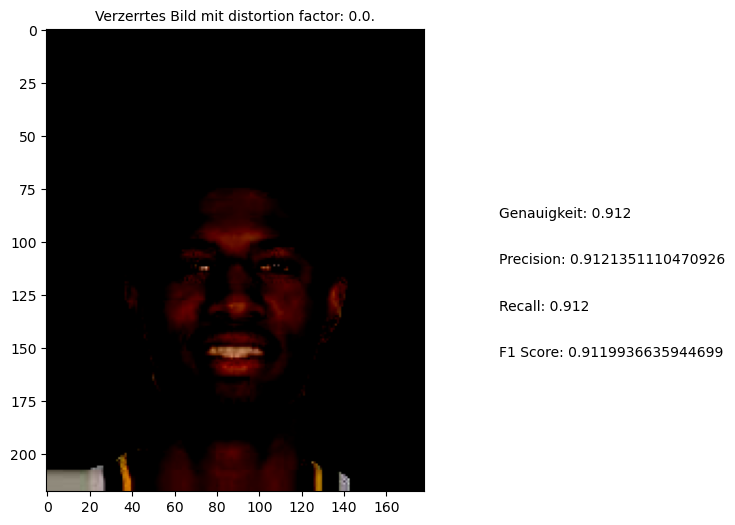

c:\Users\busse\anaconda3\Lib\site-packages\torchvision\transforms\functional.py:708: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  b_matrix = torch.tensor(startpoints, dtype=torch.float).view(8)


Test mit distortion factor: 0.0001


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Accuracy: 0.8905
Precision: 0.891090625
Recall: 0.8905
F1 Score: 0.8904562089718204


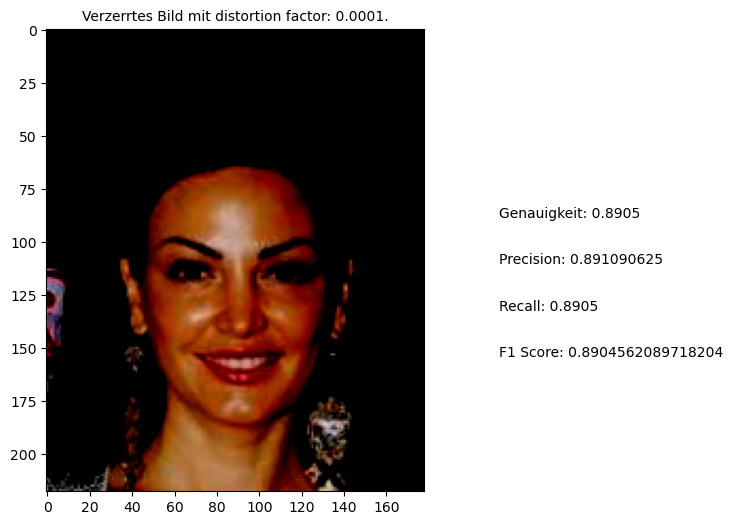

c:\Users\busse\anaconda3\Lib\site-packages\torchvision\transforms\functional.py:708: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  b_matrix = torch.tensor(startpoints, dtype=torch.float).view(8)


Test mit distortion factor: 0.0002


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Accuracy: 0.823
Precision: 0.8241564832742636
Recall: 0.823
F1 Score: 0.8228352316576228


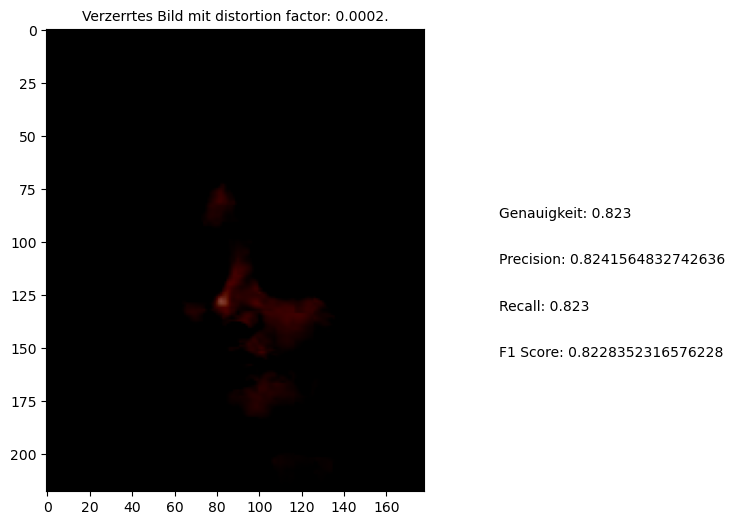

c:\Users\busse\anaconda3\Lib\site-packages\torchvision\transforms\functional.py:708: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  b_matrix = torch.tensor(startpoints, dtype=torch.float).view(8)


Test mit distortion factor: 0.00030000000000000003


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Accuracy: 0.73
Precision: 0.7307386343689661
Recall: 0.73
F1 Score: 0.7297957310879631


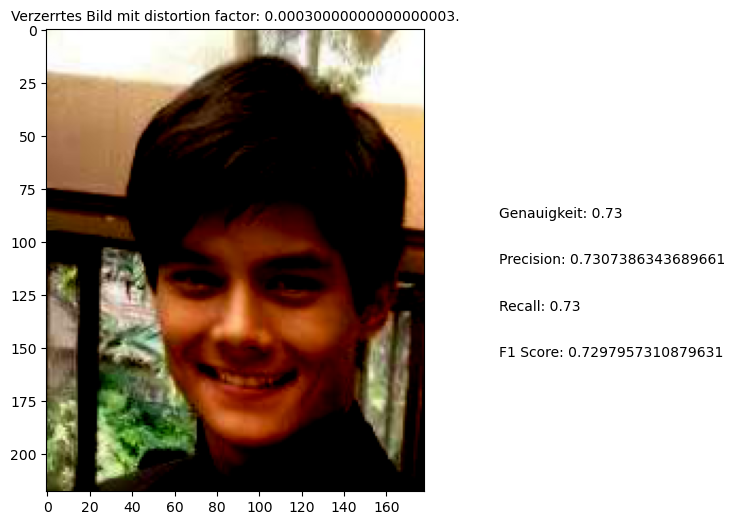

c:\Users\busse\anaconda3\Lib\site-packages\torchvision\transforms\functional.py:708: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  b_matrix = torch.tensor(startpoints, dtype=torch.float).view(8)


Test mit distortion factor: 0.0004


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Accuracy: 0.627
Precision: 0.6323671442806583
Recall: 0.627
F1 Score: 0.6232707496169961


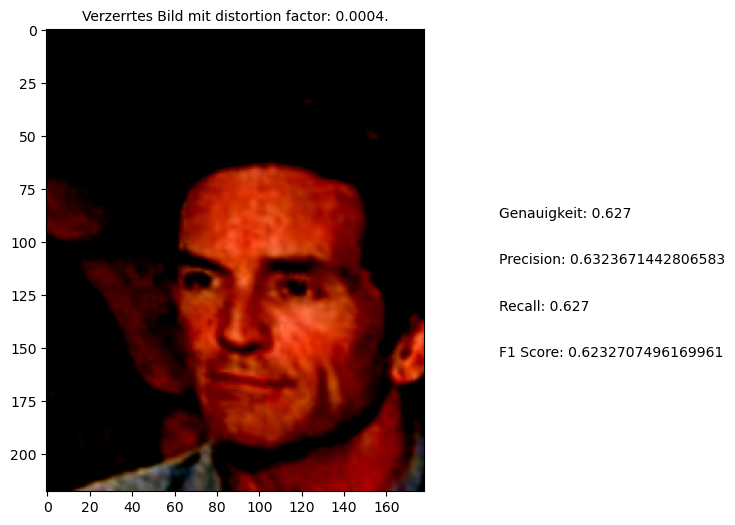

c:\Users\busse\anaconda3\Lib\site-packages\torchvision\transforms\functional.py:708: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  b_matrix = torch.tensor(startpoints, dtype=torch.float).view(8)


Test mit distortion factor: 0.0005


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Accuracy: 0.5855
Precision: 0.5919668751798453
Recall: 0.5855
F1 Score: 0.5782636319683285


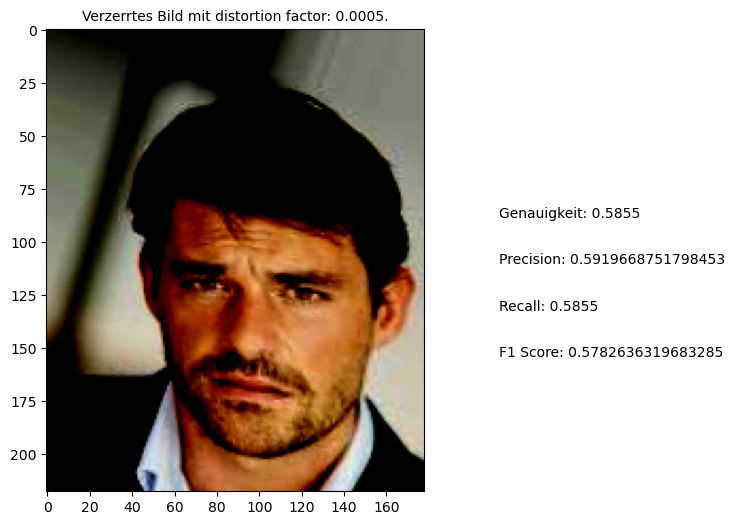

c:\Users\busse\anaconda3\Lib\site-packages\torchvision\transforms\functional.py:708: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  b_matrix = torch.tensor(startpoints, dtype=torch.float).view(8)


Test mit distortion factor: 0.0006000000000000001


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Accuracy: 0.5655
Precision: 0.5806571770334928
Recall: 0.5655
F1 Score: 0.5444466774931281


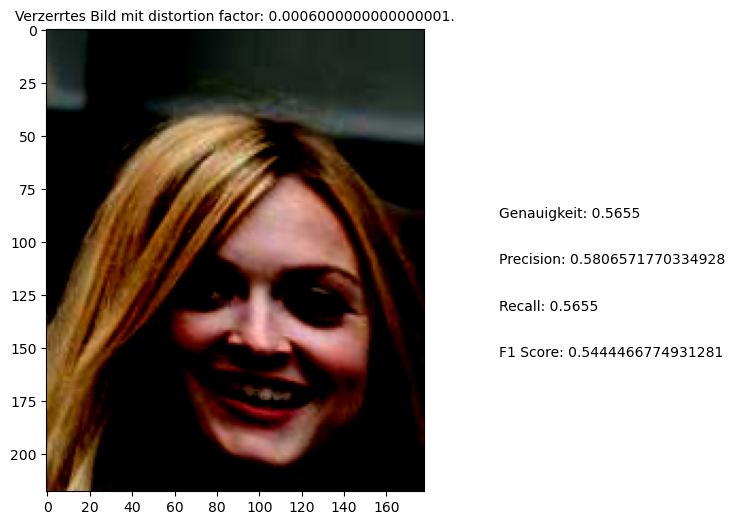

c:\Users\busse\anaconda3\Lib\site-packages\torchvision\transforms\functional.py:708: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  b_matrix = torch.tensor(startpoints, dtype=torch.float).view(8)


Test mit distortion factor: 0.0007000000000000001


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Accuracy: 0.5565
Precision: 0.5859314159292036
Recall: 0.5565
F1 Score: 0.515482620461392


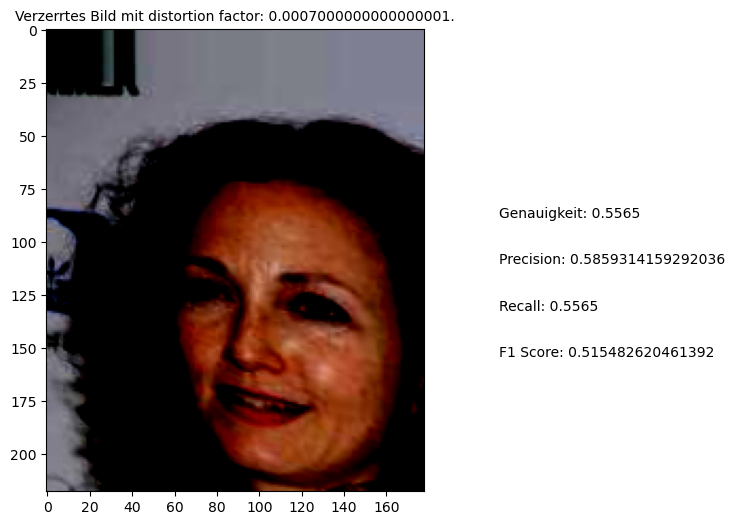

c:\Users\busse\anaconda3\Lib\site-packages\torchvision\transforms\functional.py:708: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  b_matrix = torch.tensor(startpoints, dtype=torch.float).view(8)


Test mit distortion factor: 0.0008000000000000001


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Accuracy: 0.565
Precision: 0.6124304555798078
Recall: 0.565
F1 Score: 0.5141737256202333


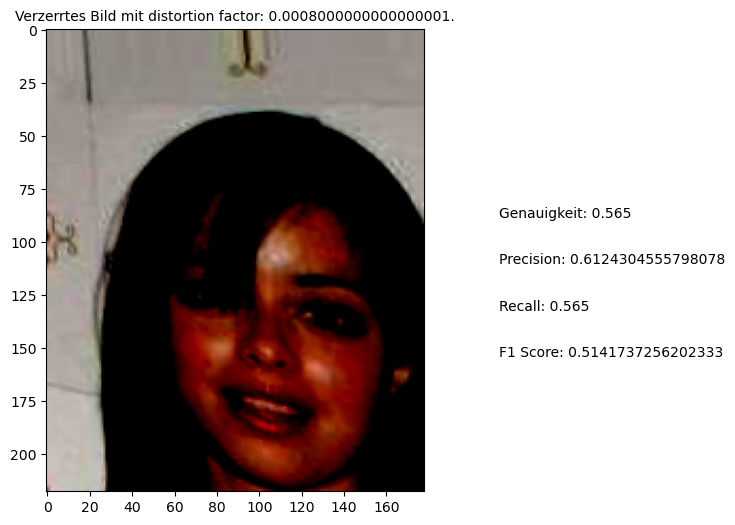

c:\Users\busse\anaconda3\Lib\site-packages\torchvision\transforms\functional.py:708: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  b_matrix = torch.tensor(startpoints, dtype=torch.float).view(8)


Test mit distortion factor: 0.0009000000000000002


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Accuracy: 0.545
Precision: 0.596287396255549
Recall: 0.545
F1 Score: 0.47575568598679385


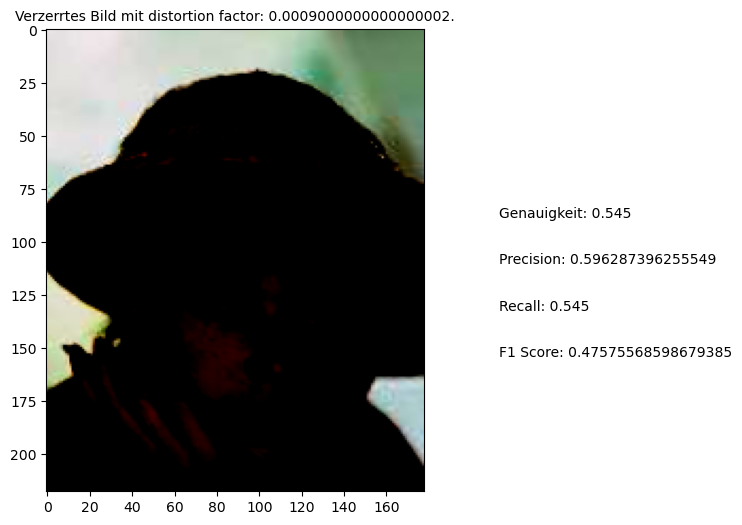

c:\Users\busse\anaconda3\Lib\site-packages\torchvision\transforms\functional.py:708: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  b_matrix = torch.tensor(startpoints, dtype=torch.float).view(8)


Test mit distortion factor: 0.0010000000000000002


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Accuracy: 0.529
Precision: 0.579953950675997
Recall: 0.529
F1 Score: 0.44065524560447583


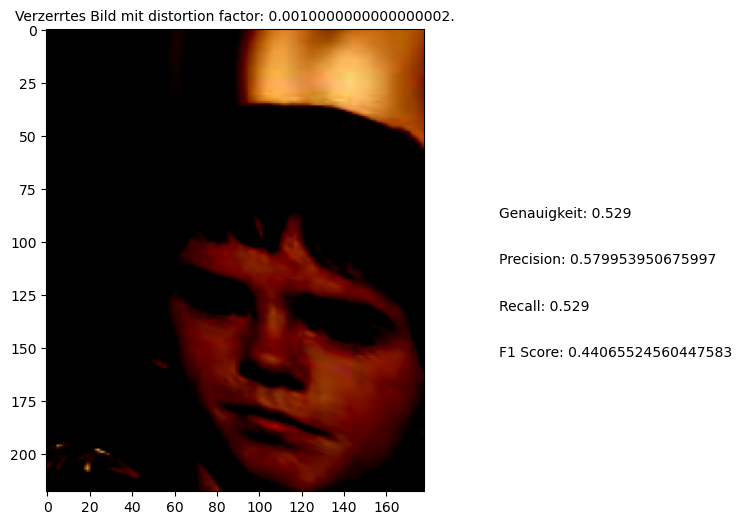

c:\Users\busse\anaconda3\Lib\site-packages\torchvision\transforms\functional.py:708: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  b_matrix = torch.tensor(startpoints, dtype=torch.float).view(8)


Test mit distortion factor: 0.0011000000000000003


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Accuracy: 0.5125
Precision: 0.5556668701423757
Recall: 0.5125
F1 Score: 0.3968376811594203


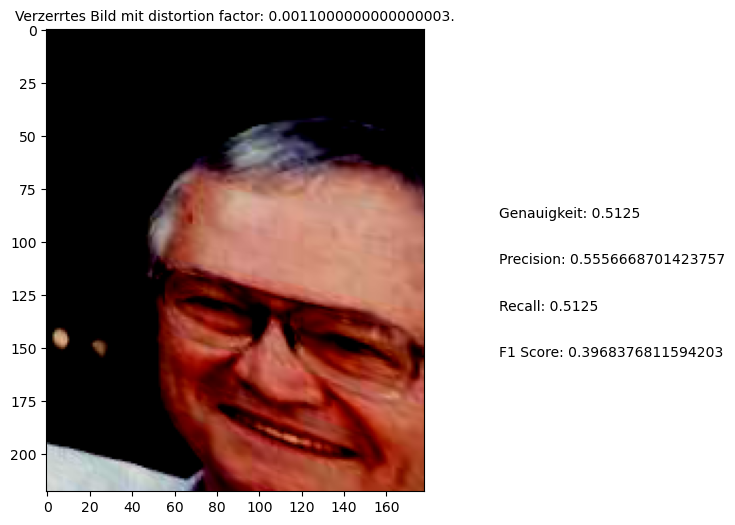

c:\Users\busse\anaconda3\Lib\site-packages\torchvision\transforms\functional.py:708: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  b_matrix = torch.tensor(startpoints, dtype=torch.float).view(8)


Test mit distortion factor: 0.0012000000000000003


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Accuracy: 0.501
Precision: 0.5096331749682061
Recall: 0.501
F1 Score: 0.3667814053779807


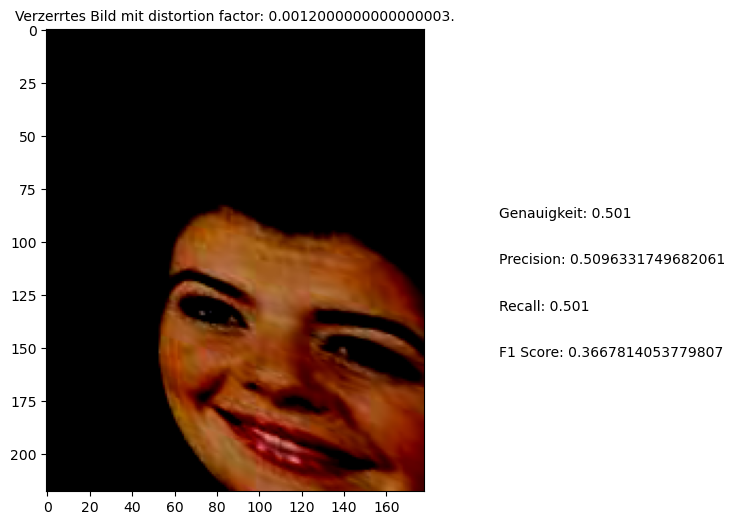

c:\Users\busse\anaconda3\Lib\site-packages\torchvision\transforms\functional.py:708: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  b_matrix = torch.tensor(startpoints, dtype=torch.float).view(8)


Test mit distortion factor: 0.0013000000000000004


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Accuracy: 0.4955
Precision: 0.4602179158110883
Recall: 0.4955
F1 Score: 0.3493937295512909


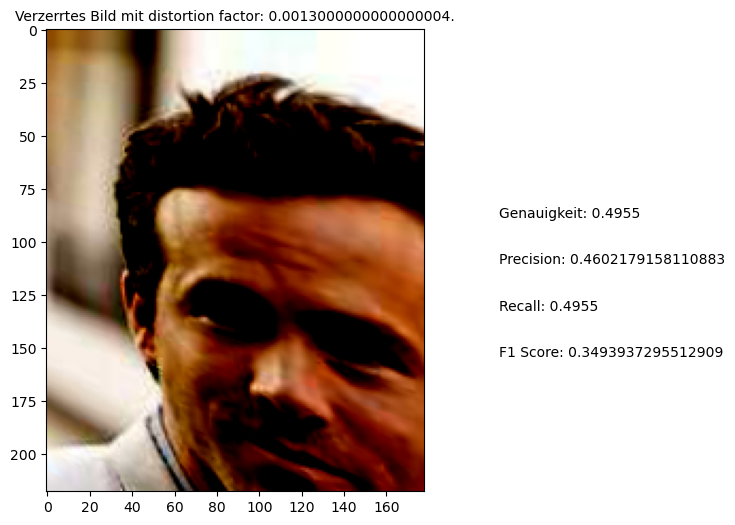

Genauigkeit unter 70% mit distortion factor: 0.0013000000000000004. Test wird gestoppt.


In [96]:
def test_distortion_robustness(model, test_dataloader, device, start_distortion=0.0, end_distortion=1.0, step=0.0001):
    distortion_factor = start_distortion

    while distortion_factor <= end_distortion:
        distorted_images = []
        labels_list = []

        for inputs, labels in test_dataloader:
            inputs_distorted = add_distortion(inputs, distortion_factor)
            distorted_images.append(inputs_distorted)
            labels_list.append(labels)

        distorted_images = torch.cat(distorted_images)
        labels_list = torch.cat(labels_list)

        distorted_dataloader = torch.utils.data.DataLoader(list(zip(distorted_images, labels_list)), batch_size=test_dataloader.batch_size)

        print(f'Test mit distortion factor: {distortion_factor}')
        accuracy, precision, recall, f1 = test_model_robustness(model, distorted_dataloader, device)
        
        # Show a sample distorted image
        plt.figure(figsize=(12, 6))
        plt.title(f'Verzerrtes Bild mit distortion factor: {distortion_factor}.', fontsize=10)
        plt.imshow(distorted_images[0].permute(1, 2, 0))
        plt.text(1.2, 0.6, f'Genauigkeit: {accuracy}', horizontalalignment='left', verticalalignment='center', transform=plt.gca().transAxes)
        plt.text(1.2, 0.5, f'Precision: {precision}', horizontalalignment='left', verticalalignment='center', transform=plt.gca().transAxes)
        plt.text(1.2, 0.4, f'Recall: {recall}', horizontalalignment='left', verticalalignment='center', transform=plt.gca().transAxes)
        plt.text(1.2, 0.3, f'F1 Score: {f1}', horizontalalignment='left', verticalalignment='center', transform=plt.gca().transAxes)
        plt.savefig(f"test/test-plots-verzerrung/plot{distortion_factor}-img.png",)
        plt.show()

        if accuracy < 0.7:
            print(f'Genauigkeit unter 70% mit distortion factor: {distortion_factor}. Test wird gestoppt.')
            break

        distortion_factor += step

test_distortion_robustness(model, test_dataloader, device)